# Notebook 07: Proposal Order Amounts

This notebook generates sales orders for the 2022H3 proposal using forecasting and regression predictions generated in [Notebook 4: Forecasting Monthly](04_Forecasting_Monthly.ipynb) and [Notebook 6: Classification Predicting Sales For New Models](05_Classification_Predict_Sales.ipynb).

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime
    
from custom_functions import *
from regression_custom_functions import *

In [2]:
# Import datasets and predictions
df_proposal = pd.read_csv('../data/cleaned_datasets/df_models.csv')
proposal_predictions = pd.read_csv('../data/predictions/proposal_forecast.csv')
new_model_predictions = pd.read_csv('../data/predictions/new_models_classifications.csv')

# Drop items not on proposal
df_proposal.dropna(subset='proposal_priority',inplace=True)

# Get names of columns for predictions
proposal_preds_column = proposal_predictions.columns[1]
new_model_preds_column = new_model_predictions.columns[1]

## Create new dataframe that merges proposal, proposal forecast, new models, and new model predictions to create an overall order.

In [3]:
df_proposal.columns[0:20]

Index(['style_id', 'max_cart_qty', 'availability', 'qty_on_hand',
       'qty_on_order', 'qty_total_inv', 'qty_sold_last_6m', 'qty_avg/mo',
       'months_of_supply', 'xyz_cost', 'qty_xyz_cost', 'wholesale_price',
       'country_of_origin', 'warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'gender'],
      dtype='object')

In [71]:
# Create new data frame for the order sheet (there is some extra columns that will be dropped later)
order_sheet_columns = ['style_id','proposal_priority', 'retail_price','gender',
                       'collection','case_size','availability', 'retail_price', 
                       'qty_on_hand','qty_on_order','qty_total_inv','planned_order',
                       'qty_sold_last_6m','qty_avg/mo','wholesale_price','xyz_cost']
order_sheet = df_proposal[order_sheet_columns]

# Merge proposal and new model predictions
order_sheet = order_sheet.merge(proposal_predictions, how = 'left', on = 'style_id')
order_sheet = order_sheet.merge(new_model_predictions, how = 'left', on = 'style_id')

# Convert predictions to an order quantity
preds_to_order(order_sheet, 5, 10) # see custom_functions for more information about how these are calculated

## Calculate other values important to XYZ

In [80]:
total_qty_on_order = order_sheet.qty_on_order.sum()
total_qty_on_order

1890.0

In [81]:
total_qty_on_hand = order_sheet.qty_on_hand.sum()
total_qty_on_hand

6102.0

In [82]:
# Calculate the total units sold in the last 6 months & average/month
last_month_sales = '2022-04' # change as needed
qty_sold_last_6m = round(return_sales(df_proposal,'style_id').rolling(6).sum()[last_month_sales].values.sum())
qty_sold_last_6m

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_28682/72967298.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  qty_sold_last_6m = round(return_sales(df_proposal,'style_id').rolling(6).sum()[last_month_sales].values.sum())


5815

In [84]:
# Calculate cost of the order
proposal_cost = round((order_sheet.xyz_cost*order_sheet.order_quantity).sum())
print(f'${proposal_cost}')

$52888


## Discussion

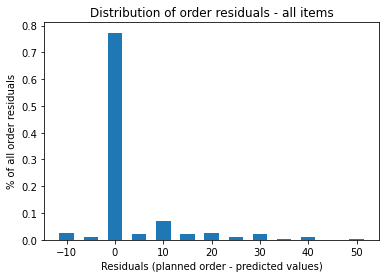

In [73]:
# Compare order to the planned order provided by XYZ
order_sheet['residuals'] = order_sheet.planned_order - order_sheet.order_quantity
residuals_counts = pd.DataFrame(order_sheet.residuals.value_counts(normalize=True)).sort_index()

plt.bar(residuals_counts.index.values, residuals_counts.residuals,width=3)
plt.title('Distribution of order residuals - all items')
plt.xlabel('Residuals (planned order - predicted values)')
plt.ylabel('% of all order residuals');

In [74]:
print(f'Of the {order_sheet.shape[0]} items on the proposal, {round(residuals_counts.loc[0,"residuals"]*100)}% of orders were identical to the planned order.')
print(f'{round(residuals_counts.loc[-10:10,"residuals"].sum()*100)}% were within +/- 10 units.')
print(f'There were {new_model_predictions.shape[0]} new models and {proposal_predictions.shape[0]} existing models on the proposal.') 

Of the 300 items on the proposal, 77% of orders were identical to the planned order.
90% were within +/- 10 units.
There were 35 new models and 265 existing models on the proposal.


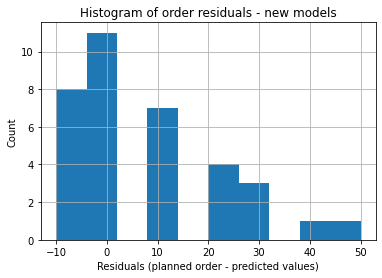

In [75]:
order_sheet[order_sheet[proposal_preds_column].astype(str) == "nan"].residuals.hist()
plt.title('Histogram of order residuals - new models')
plt.xlabel('Residuals (planned order - predicted values)')
plt.ylabel('Count');

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


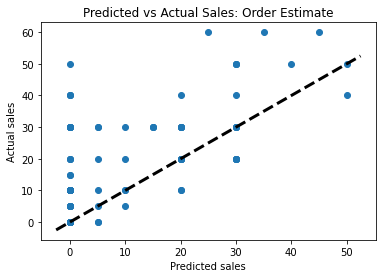

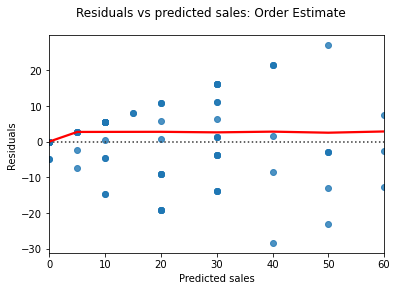

In [76]:
plot_preds(order_sheet['planned_order'], order_sheet['order_quantity'], 'Order Estimate')

The predicted sales versus the actual sales generally followed a linear trend, and the residuals are linear across the y axis. However, the error becomes much larger as predicted sales increases, indicating that model does not predict large sales well. However, this makes up a minority of models (typically only new models). This is an improvement area.

In [77]:
rmse = mean_squared_error(order_sheet['planned_order'],order_sheet['order_quantity'],squared=False)
mean_planned = order_sheet['planned_order'].mean()
mean_preds = order_sheet['order_quantity'].mean()

print(f"The root mean squared error of the orders is {round(rmse,2)} units.")
print(f"The mean of the planned orders is {round(mean_planned,2)} units.")
print(f"The mean of the predicted orders is {round(mean_preds,2)} units.")

The root mean squared error of the orders is 8.89 units.
The mean of the planned orders is 6.33 units.
The mean of the predicted orders is 3.42 units.


In [10]:
order_sheet.to_csv('../data/predictions/order_sheet.csv',index=False)